CUDA 11.3, tensorflow 2.8
** Kernel Restarting in Jupyter Lab/Notebook -> zlib123dll

In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, img_to_array, load_img

#from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
#from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# gpu 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17067952947878586435
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5948551168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8003271040360531085
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 Super with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
input_shape = (128, 128, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

In [4]:
print('fake len=', len(fake_data), 'real len=', len(real_data))

fake len= 2986 real len= 759


In [5]:
X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

In [6]:
# Check
print(np.array(X).shape)
print(np.array(Y).shape)
print(X[0:3])
print(Y[0:3])

(3745, 49152)
(3745,)
[array([0.38431373, 0.25490198, 0.21176471, ..., 0.28235295, 0.14509805,
       0.14901961], dtype=float32), array([0.1882353 , 0.1254902 , 0.11764706, ..., 0.40392157, 0.57254905,
       0.4627451 ], dtype=float32), array([0.17254902, 0.12941177, 0.11764706, ..., 0.39607844, 0.56078434,
       0.44313726], dtype=float32)]
[1, 1, 1]


In [7]:
Y_val_org = Y

# Normalization
X = np.array(X)
Y = to_categorical(Y, 2) # one-hot encoding

In [8]:
print(X[0:2])
print(Y[0:2])
print(Y_val_org[0:2])
print(X.shape)

[[0.38431373 0.25490198 0.21176471 ... 0.28235295 0.14509805 0.14901961]
 [0.1882353  0.1254902  0.11764706 ... 0.40392157 0.57254905 0.4627451 ]]
[[0. 1.]
 [0. 1.]]
[1, 1]
(3745, 49152)


In [9]:
# Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [10]:
print(len(X_train))
print(len(X_test))
Y_test[0:3]

2996
749


array([[1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

#### Training

InceptionResNetV2, EfficientNetB4

In [11]:
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
#from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

##### GPU 사용  
https://www.tensorflow.org/guide/gpu?hl=ko  
tf.config.experimental.set_memory_growth를 호출하여 메모리 증가를 허용하는 것입니다. 이는 런타임에서 할당하는데 필요한 양만큼의 GPU 메모리를 할당합니다: 처음에는 메모리를 조금만 할당하고, 프로그램이 실행되어 더 많은 GPU 메모리가 필요하면, 텐서플로 프로세스에 할당된 GPU 메모리 영역을 확장합니다. 메모리 해제는 메모리 단편화를 악화시키므로 메모리 해제는 하지 않습니다. 특정 GPU의 메모리 증가를 허용하려면 다음 코드를 텐서나 연산 앞에 입력하세요.

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
#gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [13]:
EfficientNetB6 = EfficientNetB6(include_top=False, weights='imagenet', input_shape=input_shape)
#EfficientNetB6.trainable = True

model = Sequential()

In [14]:
model.add(EfficientNetB6)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional)  (None, 4, 4, 2304)       40960143  
                                                                 
 global_average_pooling2d (G  (None, 2304)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4610      
                                                                 
Total params: 40,964,753
Trainable params: 40,740,314
Non-trainable params: 224,439
_________________________________________________________________


C:\Users\sky\.conda\envs\tf2.8\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
# Currently not used
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 30
BATCH_SIZE = 10

#with tf.device('/device:GPU:0'):
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2, verbose = 1)

Epoch 1/30
240/240 [==============================] - 88s 275ms/step - loss: 0.6470 - accuracy: 0.6553 - val_loss: 0.5713 - val_accuracy: 0.7883
Epoch 2/30
240/240 [==============================] - 61s 256ms/step - loss: 0.5480 - accuracy: 0.7763 - val_loss: 0.5341 - val_accuracy: 0.7883
Epoch 3/30
240/240 [==============================] - 60s 249ms/step - loss: 0.4427 - accuracy: 0.8497 - val_loss: 0.4948 - val_accuracy: 0.7900
Epoch 4/30
240/240 [==============================] - 60s 250ms/step - loss: 0.3447 - accuracy: 0.8848 - val_loss: 0.3765 - val_accuracy: 0.8733
Epoch 5/30
240/240 [==============================] - 60s 250ms/step - loss: 0.2671 - accuracy: 0.9115 - val_loss: 0.3019 - val_accuracy: 0.8950
Epoch 6/30
240/240 [==============================] - 60s 251ms/step - loss: 0.2086 - accuracy: 0.9249 - val_loss: 0.2559 - val_accuracy: 0.9150
Epoch 7/30
240/240 [==============================] - 60s 250ms/step - loss: 0.1664 - accuracy: 0.9470 - val_loss: 0.2374 - val_ac

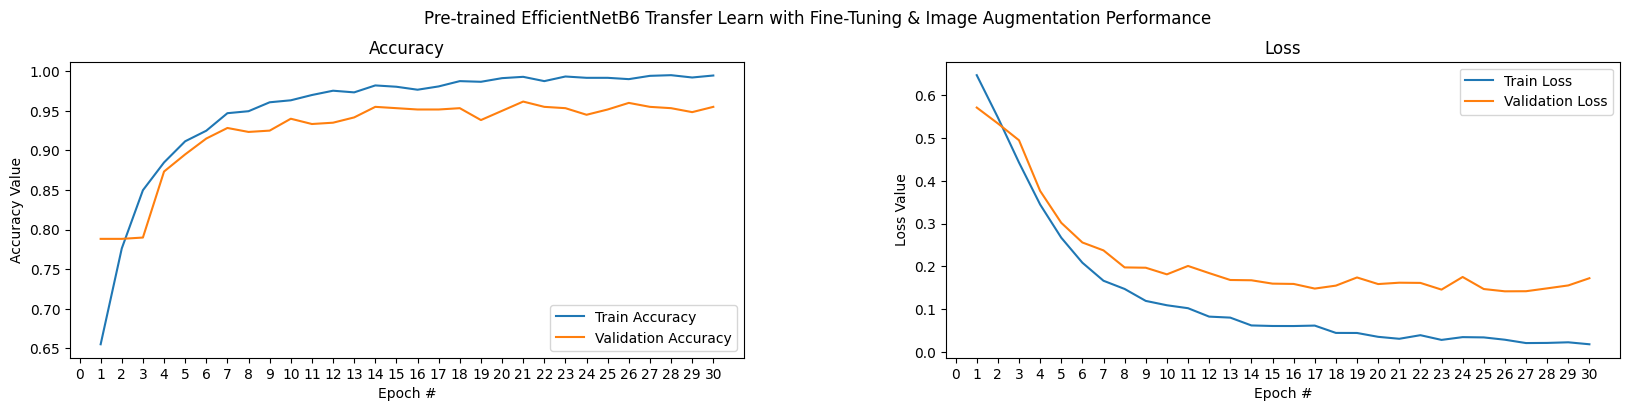

In [16]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained EfficientNetB6 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
# Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

In [18]:
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(Y_test, axis=1)
print(pred)
print(y_pred[0:4], y_true[0:4])

[[1.00000000e+00 1.10648513e-08]
 [1.00000000e+00 4.27333946e-09]
 [1.00000000e+00 9.68999048e-11]
 ...
 [1.00000000e+00 7.49403917e-09]
 [9.99999881e-01 1.12820786e-07]
 [1.73422415e-02 9.82657731e-01]]
[0 0 0 0] [0 0 0 0]


True positive =  573
False positive =  16
False negative =  20
True negative =  140




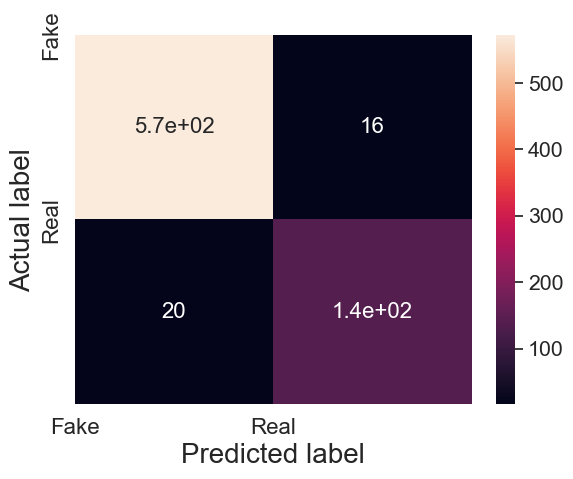

In [19]:
print_confusion_matrix(y_true, y_pred)

In [20]:
model.save('deepfake-detection-model-EfficientNetB5.h5')